In [1]:
import scanpy as sc
import warnings
import numpy as np
import bbknn
warnings.filterwarnings('ignore')

C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\google\protobuf\descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message
C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1287: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  _pywrap_tensorflow.RegisterType("Sequence", _collections.Sequence)
C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\tracking\object_identity.py:112: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class ObjectIdentitySet(collections.MutableSet):
C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\si

In [2]:
adata=sc.read("/Users/lsimon/OneDrive/Miko/UTHealth/projects/BatchBalancedTriplets/data/MouseAtlas/MouseAtlas.subset.h5ad")

In [3]:
subset=adata[adata.obs["Dataset"].isin(["Tabula(Plate)", "Tabula(Droplet)"])]

In [4]:
sc.pp.pca(subset)
sc.pp.neighbors(subset)
sc.tl.umap(subset)

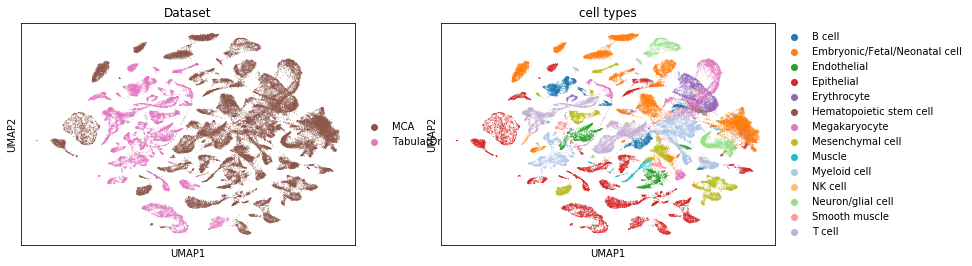

In [5]:
sc.pl.umap(subset, color = ["Dataset", "cell types"])

In [5]:
bdata = subset

In [6]:
bdata

AnnData object with n_obs × n_vars = 77077 × 2797 
    obs: 'Organ', 'n_genes', 'n_counts', 'sample', 'louvain', 'summary2', 'batch', 'organ_sample', 'cnk', 'smp_org', 'chk', 'summary1', 'Organ groups', 'organ groups', 'cell types', 'Dataset', 'Cell types', 'Hox_genes'
    var: 'GeneName', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell types_colors', 'Dataset_colors', 'Organ groups_colors', 'cell types_colors', 'idx', 'louvain', 'louvain_colors', 'neighbors', 'organ groups_colors', 'pca', 'rank_genes_groups', 'sample_color', 'sample_colors', 'summary1_colors', 'summary2_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_3D'
    varm: 'PCs'

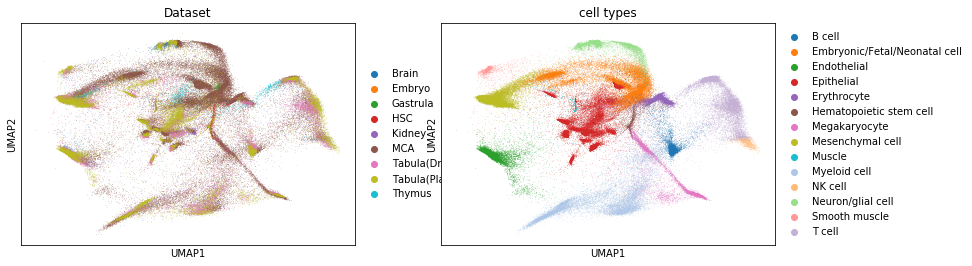

In [15]:
bdata.obsm["X_umap"]=embedding
sc.pl.umap(bdata, color = ["Dataset", "cell types"])

In [7]:
bdata

AnnData object with n_obs × n_vars = 77077 × 2797 
    obs: 'Organ', 'n_genes', 'n_counts', 'sample', 'louvain', 'summary2', 'batch', 'organ_sample', 'cnk', 'smp_org', 'chk', 'summary1', 'Organ groups', 'organ groups', 'cell types', 'Dataset', 'Cell types', 'Hox_genes'
    var: 'GeneName', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell types_colors', 'Dataset_colors', 'Organ groups_colors', 'cell types_colors', 'idx', 'louvain', 'louvain_colors', 'neighbors', 'organ groups_colors', 'pca', 'rank_genes_groups', 'sample_color', 'sample_colors', 'summary1_colors', 'summary2_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_3D'
    varm: 'PCs'

In [10]:
import bbknn

knn_distances, knn_indices=bbknn.get_graph(pca=bdata.obsm["X_pca"], batch_list = bdata.obs["Dataset"],
                                            neighbors_within_batch=10, n_pcs=50, approx=True, metric="euclidean", use_faiss=True, n_trees=50)
neighbour_matrix = knn_indices

In [11]:
#!/usr/bin/env python
# coding: utf-8

import scanpy as sc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = 'once')
import os
import sys


from ivis.nn.losses import triplet_loss, is_categorical, is_multiclass, is_hinge
#from ivis.nn.network import base_network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, AlphaDropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
import io
import json
import shutil
import multiprocessing
from scipy.sparse import issparse
import bbknn
from tensorflow.keras import backend as K
import tensorflow as tf
from ivis import Ivis
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn import metrics
import time
from datetime import timedelta


## setting GPU No. for training
os.environ["CUDA_VISIBLE_DEVICES"] = '2' #use GPU with ID=0
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8 # maximun alloc gpu50% of MEM
#config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.compat.v1.Session(config = config)


## setting CPU
cpu_config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 20, inter_op_parallelism_threads = 20, device_count = {'CPU': 20})
#with tf.Session(config = cpu_config) as sess
sess = tf.compat.v1.Session(config = cpu_config)


sc.set_figure_params(dpi_save = 300, vector_friendly = True)



def triplet_network(base_network, embedding_dims=2, embedding_l1=0.000, embedding_l2=0.01):
    def output_shape(shapes):
        shape1, shape2, shape3 = shapes
        return (3, shape1[0],)

    input_a = Input(shape=base_network.input_shape[1:])
    input_p = Input(shape=base_network.input_shape[1:])
    input_n = Input(shape=base_network.input_shape[1:])

    embeddings = Dense(embedding_dims,
                       kernel_regularizer=l1_l2(l1=embedding_l1, l2=embedding_l2))(base_network.output)
    network = Model(base_network.input, embeddings)

    processed_a = network(input_a)
    processed_p = network(input_p)
    processed_n = network(input_n)

    triplet = Lambda(K.stack,
                     output_shape=output_shape,
                     name='stacked_triplets')([processed_a,
                                               processed_p,
                                               processed_n],)
    model = Model([input_a, input_p, input_n], triplet)

    return model, processed_a, processed_p, processed_n


## Base network

def base_network(model_name, input_shape):
    '''Return the defined base_network defined by the model_name string.
    '''
    if model_name == 'szubert':
        return szubert_base_network(input_shape)
    elif model_name == 'hinton':
        return hinton_base_network(input_shape)
    elif model_name == 'maaten':
        return maaten_base_network(input_shape)

    raise NotImplementedError(
        'Base network {} is not implemented'.format(model_name))


def get_base_networks():
    return ['szubert', 'hinton', 'maaten']


def szubert_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='selu',
              kernel_initializer='lecun_normal')(inputs)
    x = AlphaDropout(0.1)(x)
    x = Dense(128, activation='selu',
              kernel_initializer='lecun_normal')(x)
    x = AlphaDropout(0.1)(x)
    x = Dense(128, activation='selu', kernel_initializer='lecun_normal')(x)
    return Model(inputs, x)


def hinton_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    inputs = Input(shape=input_shape)
    x = Dense(1000, activation='selu',
              kernel_initializer='lecun_normal')(inputs)
    x = AlphaDropout(0.2)(x)
    x = Dense(500, activation='selu', kernel_initializer='lecun_normal')(x)
    x = AlphaDropout(0.2)(x)
    x = Dense(100, activation='selu', kernel_initializer='lecun_normal')(x)
    return Model(inputs, x)


def maaten_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    inputs = Input(shape=input_shape)
    x = Dense(500, activation='selu',
              kernel_initializer='lecun_normal')(inputs)
    x = AlphaDropout(0.1)(x)
    x = Dense(500, activation='selu', kernel_initializer='lecun_normal')(x)
    x = AlphaDropout(0.1)(x)
    x = Dense(2000, activation='selu', kernel_initializer='lecun_normal')(x)
    return Model(inputs, x)


class KnnTripletGenerator(Sequence):

    def __init__(self, X, batch, neighbour_matrix, batch_size=32):
        self.X = X
        self.batch = batch
        self.neighbour_matrix = neighbour_matrix
        self.batch_size = batch_size
        self.placeholder_labels = np.empty(batch_size, dtype=np.uint8)

    def __len__(self):
        return int(np.ceil(self.X.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.X.shape[0]))

        placeholder_labels = self.placeholder_labels[:len(batch_indices)]
        triplet_batch = [self.knn_triplet_from_neighbour_list(row_index, self.neighbour_matrix[row_index]) for row_index in batch_indices]

        if (issparse(self.X)):
            triplet_batch = [[e.toarray()[0] for e in t] for t in triplet_batch]
        triplet_batch = np.array(triplet_batch)

        return tuple([triplet_batch[:, 0], triplet_batch[:, 1], triplet_batch[:, 2]]), placeholder_labels

    def knn_triplet_from_neighbour_list(self, row_index, neighbour_list):
        """ A random (unweighted) positive example chosen. """
        triplets = []

        # Take a random neighbour as positive
        neighbour_ind = np.random.choice(neighbour_list)
        neighbour_ind2 = np.random.choice(neighbour_list)

        # Take a random non-neighbour as negative
        # Pick a random index until one fits constraint. An optimization.
        negative_ind = np.random.randint(0, self.X.shape[0])
        while negative_ind  in neighbour_list:
            negative_ind = np.random.randint(0, self.X.shape[0])

        negative_ind2 = np.random.randint(0, self.X.shape[0])
        while negative_ind2  in neighbour_list:
            negative_ind2 = np.random.randint(0, self.X.shape[0])

        triplets += [self.X[row_index], self.X[neighbour_ind],
                     self.X[negative_ind]]

        triplets += [self.X[row_index], self.X[neighbour_ind2],
                     self.X[negative_ind2]]
        return triplets



class LabeledKnnTripletGenerator(Sequence):

    def __init__(self, X, Y, neighbour_matrix, batch_size=32):
        self.X, self.Y = X, Y
        self.batch = batch
        self.neighbour_matrix = neighbour_matrix
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(self.X.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.X.shape[0]))

        label_batch = self.Y[batch_indices]
        triplet_batch = [self.knn_triplet_from_neighbour_list(row_index, self.neighbour_matrix[row_index]) for row_index in batch_indices]

        if (issparse(self.X)):
            triplet_batch = [[e.toarray()[0] for e in t] for t in triplet_batch]

        triplet_batch = np.array(triplet_batch)

        return tuple([triplet_batch[:, 0], triplet_batch[:, 1], triplet_batch[:, 2]]), tuple([np.array(label_batch), np.array(label_batch)])

    def knn_triplet_from_neighbour_list(self, row_index, neighbour_list):
        """ A random (unweighted) positive example chosen. """
        triplets = []

        # Take a random neighbour as positive
        neighbour_ind = np.random.choice(neighbour_list)

        # Take a random non-neighbour as negative
        # Pick a random index until one fits constraint. An optimization.
        negative_ind = np.random.randint(0, self.X.shape[0])
        while negative_ind  in neighbour_list:
            negative_ind = np.random.randint(0, self.X.shape[0])

        triplets += [self.X[row_index],
                     self.X[neighbour_ind],
                     self.X[negative_ind]]
        return triplets


def generator_from_index(X, Y, k = 15, batch_size = 128, batch_list = 4, search_k=-1, verbose=1):
        if k >= X.shape[0] - 1:
                raise Exception('''k value greater than or equal to (num_rows - 1)(k={}, rows={}). Lower k to a smaller value.'''.format(k, X.shape[0]))

        if batch_size > X.shape[0]:
                raise Exception('''batch_size value larger than num_rows in dataset (batch_size={}, rows={}). Lower batch_size to a smaller value.'''.format(batch_size, X.shape[0]))

        if Y is None:
            return KnnTripletGenerator(X = X,  batch = batch_list, neighbour_matrix = neighbour_matrix, batch_size=batch_size)
        else:
            return LabeledKnnTripletGenerator(X = X, Y = Y,  neighbour_matrix = neighbour_matrix, batch_size=batch_size)


class BBTNN(BaseEstimator):
    def __init__(self, embedding_dims=2, k=150, distance='pn', batch_size=128, batch_list = 4 ,
                 epochs=1000, n_epochs_without_progress=50,
                 margin=1, ntrees=50, search_k=-1,
                 model='szubert',supervision_metric='sparse_categorical_crossentropy',
                 supervision_weight=0.8,
                 callbacks=[], eager_execution=False, verbose=1):

        self.embedding_dims = embedding_dims
        self.k = k
        self.distance = distance
        self.batch_size = batch_size
        self.batch_list = batch_list
        self.epochs = epochs
        self.n_epochs_without_progress = n_epochs_without_progress
        self.margin = margin
        self.ntrees = ntrees
        self.search_k = search_k
        self.model_def = model
        self.model_ = None
        self.encoder = None
        self.supervision_metric = supervision_metric
        self.supervision_weight = supervision_weight
        self.loss_history_ = []
        self.callbacks = callbacks
        for callback in self.callbacks:
            if isinstance(callback, ModelCheckpoint):
                callback = callback.register_ivis_model(self)
        self.eager_execution = eager_execution
        if not eager_execution:
            tf.compat.v1.disable_eager_execution()
        self.verbose = verbose

    def __getstate__(self):
        """ Return object serializable variable dict """

        state = dict(self.__dict__)
        if 'model_' in state:
            state['model_'] = None
        if 'encoder' in state:
            state['encoder'] = None
        if 'supervised_model_' in state:
            state['supervised_model_'] = None
        if 'callbacks' in state:
            state['callbacks'] = []
        if not isinstance(state['model_def'], str):
            state['model_def'] = None
        return state

    def _fit(self, X, Y=None, shuffle_mode=True):

        datagen = generator_from_index(X, Y,
                                       k=self.k,
                                       batch_size=self.batch_size,
                                       batch_list = self.batch_list,
                                       search_k=self.search_k,
                                       verbose=self.verbose)

        loss_monitor = 'loss'
        try:
            triplet_loss_func = triplet_loss(distance=self.distance,
                                             margin=self.margin)
        except KeyError:
            raise ValueError('Loss function `{}` not implemented.'.format(self.distance))

        if self.model_ is None:
            if type(self.model_def) is str:
                input_size = (X.shape[-1],)
                self.model_, anchor_embedding, _, _ = \
                    triplet_network(base_network(self.model_def, input_size),
                                    embedding_dims=self.embedding_dims)
            else:
                self.model_, anchor_embedding, _, _ = \
                    triplet_network(self.model_def,
                                    embedding_dims=self.embedding_dims)

            if Y is None:
                self.model_.compile(optimizer='adam', loss=triplet_loss_func)
            else:
                if is_categorical(self.supervision_metric):
                    if not is_multiclass(self.supervision_metric):
                        if not is_hinge(self.supervision_metric):
                            # Binary logistic classifier
                            if len(Y.shape) > 1:
                                self.n_classes = Y.shape[-1]
                            else:
                                self.n_classes = 1
                            supervised_output = Dense(self.n_classes, activation='sigmoid',
                                                      name='supervised')(anchor_embedding)
                        else:
                            # Binary Linear SVM output
                            if len(Y.shape) > 1:
                                self.n_classes = Y.shape[-1]
                            else:
                                self.n_classes = 1
                            supervised_output = Dense(self.n_classes, activation='linear',
                                                      name='supervised',
                                                      kernel_regularizer=regularizers.l1(l1=0.01))(anchor_embedding)
                    else:
                        if not is_hinge(self.supervision_metric):
                            validate_sparse_labels(Y)
                            self.n_classes = len(np.unique(Y[Y != np.array(-1)]))
                            # Softmax classifier
                            supervised_output = Dense(self.n_classes, activation='softmax',
                                                      name='supervised')(anchor_embedding)
                        else:
                            self.n_classes = len(np.unique(Y, axis=0))
                            # Multiclass Linear SVM output
                            supervised_output = Dense(self.n_classes, activation='linear',
                                                      name='supervised',
                                                      kernel_regularizer=regularizers.l1(l1=0.01))(anchor_embedding)
                else:
                    # Regression
                    if len(Y.shape) > 1:
                        self.n_classes = Y.shape[-1]
                    else:
                        self.n_classes = 1
                    supervised_output = Dense(self.n_classes, activation='linear',
                                              name='supervised')(anchor_embedding)

                supervised_loss = keras.losses.get(self.supervision_metric)
                if self.supervision_metric == 'sparse_categorical_crossentropy':
                    supervised_loss = semi_supervised_loss(supervised_loss)

                final_network = Model(inputs=self.model_.inputs,
                                      outputs=[self.model_.output,
                                               supervised_output])
                self.model_ = final_network
                self.model_.compile(
                    optimizer='adam',
                    loss={
                        'stacked_triplets': triplet_loss_func,
                        'supervised': supervised_loss
                         },
                    loss_weights={
                        'stacked_triplets': 1 - self.supervision_weight,
                        'supervised': self.supervision_weight})

                # Store dedicated classification model
                supervised_model_input = Input(shape=(X.shape[-1],))
                embedding = self.model_.layers[3](supervised_model_input)
                softmax_out = self.model_.layers[-1](embedding)

                self.supervised_model_ = Model(supervised_model_input, softmax_out)

        self.encoder = self.model_.layers[3]

        if self.verbose > 0:
            print('Training neural network')

        hist = self.model_.fit(
            datagen,
            epochs=self.epochs,
            callbacks=[callback for callback in self.callbacks] +
                      [EarlyStopping(monitor=loss_monitor,
                       patience=self.n_epochs_without_progress)],
            shuffle=shuffle_mode,
            workers = 10,
            verbose=self.verbose)
        self.loss_history_ += hist.history['loss']


    def fit(self, X, Y=None, shuffle_mode=True):
        """Fit an ivis model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Data to be embedded.
        Y : array, shape (n_samples)
            Optional array for supervised dimentionality reduction.

        Returns
        -------
        returns an instance of self
        """

        self._fit(X, Y, shuffle_mode)
        return self

    def fit_transform(self, X, Y=None, shuffle_mode=True):
        """Fit to data then transform

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Data to be embedded.
        Y : array, shape (n_samples)
            Optional array for supervised dimentionality reduction.


        Returns
        -------
        X_new : transformed array, shape (n_samples, embedding_dims)
            Embedding of the new data in low-dimensional space.
        """

        self.fit(X, Y, shuffle_mode)
        return self.transform(X)

    def transform(self, X):
        """Transform X into the existing embedded space and return that
        transformed output.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            New data to be transformed.

        Returns
        -------
        X_new : array, shape (n_samples, embedding_dims)
            Embedding of the new data in low-dimensional space.
        """

        embedding = self.encoder.predict(X, verbose=self.verbose)
        return embedding

    def score_samples(self, X):
        """Passes X through classification network to obtain predicted
        supervised values. Only applicable when trained in
        supervised mode.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Data to be passed through classification network.
        Returns
        -------
        X_new : array, shape (n_samples, embedding_dims)
            Softmax class probabilities of the data.
        """

        if self.supervised_model_ is None:
            raise Exception("Model was not trained in classification mode.")

        softmax_output = self.supervised_model_.predict(X, verbose=self.verbose)
        return softmax_output


def semi_supervised_loss(loss_function):
    def new_loss_function(y_true, y_pred):
        mask = tf.cast(~tf.math.equal(y_true, -1), tf.float32)
        y_true_pos = tf.nn.relu(y_true)
        loss = loss_function(y_true_pos, y_pred)
        masked_loss = loss * mask
        return masked_loss
    new_func = new_loss_function
    new_func.__name__ = loss_function.__name__
    return new_func

def validate_sparse_labels(Y):
    if not zero_indexed(Y):
        raise ValueError('Ensure that your labels are zero-indexed')
    if not consecutive_indexed(Y):
        raise ValueError('Ensure that your labels are indexed consecutively')

def zero_indexed(Y):
    if min(abs(Y)) != 0:
        return False
    return True

def consecutive_indexed(Y):
    """ Assumes that Y is zero-indexed. """
    n_classes = len(np.unique(Y[Y != np.array(-1)]))
    if max(Y) >= n_classes:
        return False
    return True


In [14]:
coordinates=[]
for i in range(0, 20):
    print("iteration " + str(i))
    num_cells = bdata.shape[0]
    
    random_indices = np.random.choice(range(0, num_cells), round(0.1*num_cells))
    
    batch = bdata.obs["Dataset"]
    X = bdata.obsm["X_pca"]
    
    model = BBTNN(batch_list = batch, epochs = 1, verbose = 1)
    model.fit_transform(X)
    embeddings = model.transform(bdata.obsm["X_pca"])
    coordinates.append(embeddings)

iteration 0
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 13us/sample
iteration 1
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 13us/sample
iteration 2
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 14us/sample
iteration 3
Training neural network
77077/77077 [==============================] - ETA: 7: - ETA: 5s - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA

77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 13us/sample
iteration 4
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 15us/sample
iteration 5
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 15us/sample
iteration 6
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA

77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 16us/sample
iteration 8
Training neural network
77077/77077 [==============================] - ETA: 37 - ETA: 1 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 17us/sample
iteration 9
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 17us/sample
iteration 10
Training neural network


77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 17us/sample
iteration 11
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 18us/sample
iteration 12
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 19us/sample
iteration 13
Training neural network


77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 19us/sample
iteration 14
Training neural network
77077/77077 [==============================] - ETA: 21 - ETA: 1 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 18us/sample
iteration 15
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 19us/sample
iteration 16
Training neural network


77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 20us/sample
iteration 17
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 20us/sample
iteration 18
Training neural network
77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 22us/sam

77077/77077 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 21us/sample


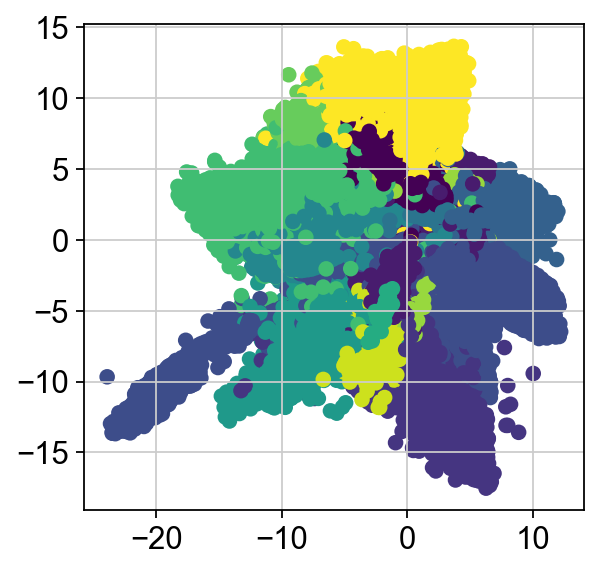

In [15]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
plt.scatter(coordinates[0][:,0], coordinates[0][:,1], c = le.fit_transform(bdata.obs["Dataset"]), s = 1)

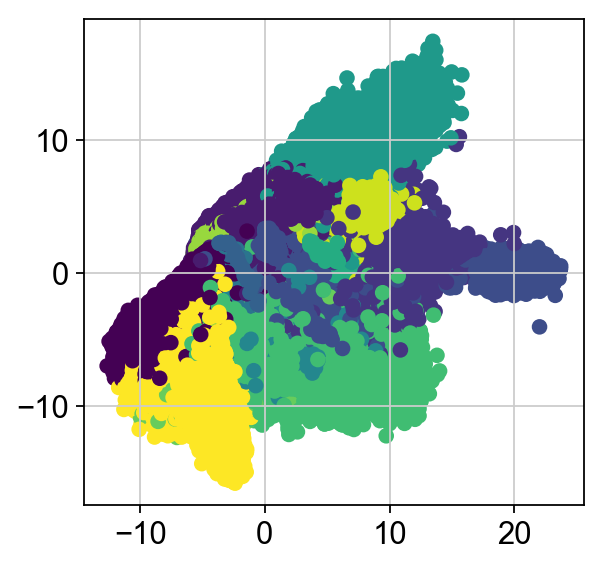

In [16]:
plt.scatter(coordinates[9][:,0], coordinates[9][:,1], c = le.fit_transform(bdata.obs["Dataset"]), s = 1)

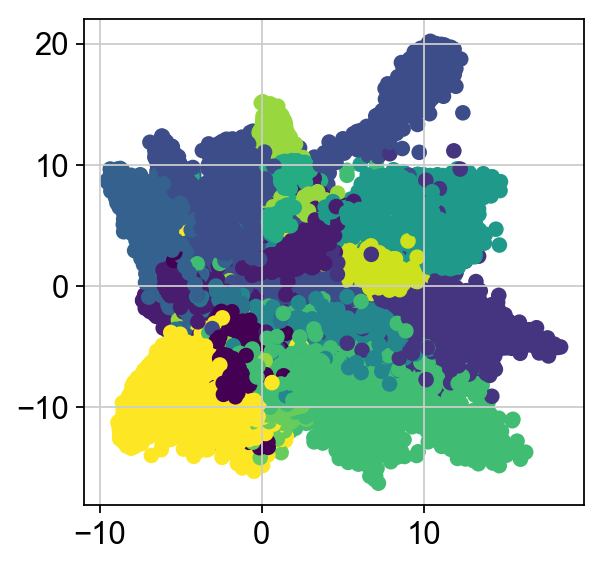

In [17]:
plt.scatter(coordinates[19][:,0], coordinates[19][:,1], c = le.fit_transform(bdata.obs["cell types"]), s = 1)

In [18]:
model = BBTNN(batch_list = batch, epochs = 100, verbose = 1, batch_size=32)
embeddings = model.fit_transform(X)

Training neural network
Epoch 1/100
2409/2409 [==============================] - ETA: 1:40:43 - loss: 1.04 - ETA: 6:50 - loss: 1.0571   - ETA: 3:35 - loss: 1.248 - ETA: 2:24 - loss: 1.088 - ETA: 1:54 - loss: 0.975 - ETA: 1:33 - loss: 0.928 - ETA: 1:20 - loss: 0.913 - ETA: 1:10 - loss: 0.912 - ETA: 1:02 - loss: 0.882 - ETA: 56s - loss: 0.859 - ETA: 50s - loss: 0.83 - ETA: 46s - loss: 0.82 - ETA: 42s - loss: 0.78 - ETA: 39s - loss: 0.78 - ETA: 37s - loss: 0.75 - ETA: 35s - loss: 0.73 - ETA: 33s - loss: 0.72 - ETA: 31s - loss: 0.70 - ETA: 30s - loss: 0.69 - ETA: 28s - loss: 0.67 - ETA: 27s - loss: 0.65 - ETA: 26s - loss: 0.63 - ETA: 25s - loss: 0.62 - ETA: 24s - loss: 0.62 - ETA: 23s - loss: 0.61 - ETA: 22s - loss: 0.61 - ETA: 21s - loss: 0.61 - ETA: 21s - loss: 0.60 - ETA: 20s - loss: 0.59 - ETA: 19s - loss: 0.58 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.54 - ETA: 17s - loss: 0.54 - ETA: 16s - loss: 0.53 - ETA: 16

2409/2409 [==============================] - ETA: 4:45 - loss: 0.296 - ETA: 29s - loss: 0.174 - ETA: 19s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 14s - loss: 0.16 - ETA: 13s - loss: 0.15 - ETA: 12s - loss: 0.16 - ETA: 11s - loss: 0.16 - ETA: 11s - loss: 0.17 - ETA: 11s - loss: 0.17 - ETA: 10s - loss: 0.17 - ETA: 10s - loss: 0.17 - ETA: 10s - loss: 0.17 - ETA: 10s - loss: 0.17 - ETA: 10s - loss: 0.17 - ETA: 9s - loss: 0.1762 - ETA: 9s - loss: 0.175 - ETA: 9s - loss: 0.173 - ETA: 9s - loss: 0.173 - ETA: 9s - loss: 0.171 - ETA: 9s - loss: 0.172 - ETA: 9s - loss: 0.173 - ETA: 9s - loss: 0.172 - ETA: 8s - loss: 0.173 - ETA: 8s - loss: 0.175 - ETA: 8s - loss: 0.175 - ETA: 8s - loss: 0.173 - ETA: 8s - loss: 0.172 - ETA: 8s - loss: 0.173 - ETA: 8s - loss: 0.173 - ETA: 8s - loss: 0.174 - ETA: 8s - loss: 0.175 - ETA: 8s - loss: 0.173 - ETA: 8s - loss: 0.173 - ETA: 7s - loss: 0.173 - ETA: 7s - loss: 0.171 - ETA: 7s - loss: 0.171 - ETA: 7s - loss: 0.172 - ETA: 7s - loss: 0.173 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:50 - loss: 0.073 - ETA: 29s - loss: 0.133 - ETA: 19s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.13 - ETA: 11s - loss: 0.13 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 9s - loss: 0.1371 - ETA: 9s - loss: 0.139 - ETA: 9s - loss: 0.139 - ETA: 9s - loss: 0.139 - ETA: 9s - loss: 0.144 - ETA: 9s - loss: 0.142 - ETA: 9s - loss: 0.141 - ETA: 9s - loss: 0.140 - ETA: 9s - loss: 0.141 - ETA: 9s - loss: 0.142 - ETA: 8s - loss: 0.142 - ETA: 8s - loss: 0.144 - ETA: 8s - loss: 0.144 - ETA: 8s - loss: 0.143 - ETA: 8s - loss: 0.143 - ETA: 8s - loss: 0.144 - ETA: 8s - loss: 0.144 - ETA: 8s - loss: 0.144 - ETA: 8s - loss: 0.143 - ETA: 8s - loss: 0.143 - ETA: 8s - loss: 0.143 - ETA: 8s - loss: 0.142 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 4:31 - loss: 0.320 - ETA: 28s - loss: 0.155 - ETA: 19s - loss: 0.14 - ETA: 16s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 12s - loss: 0.15 - ETA: 12s - loss: 0.15 - ETA: 11s - loss: 0.14 - ETA: 11s - loss: 0.14 - ETA: 11s - loss: 0.14 - ETA: 11s - loss: 0.13 - ETA: 10s - loss: 0.14 - ETA: 10s - loss: 0.14 - ETA: 10s - loss: 0.14 - ETA: 10s - loss: 0.15 - ETA: 10s - loss: 0.15 - ETA: 10s - loss: 0.14 - ETA: 10s - loss: 0.14 - ETA: 9s - loss: 0.1433 - ETA: 9s - loss: 0.143 - ETA: 9s - loss: 0.141 - ETA: 9s - loss: 0.138 - ETA: 9s - loss: 0.137 - ETA: 9s - loss: 0.138 - ETA: 9s - loss: 0.137 - ETA: 8s - loss: 0.135 - ETA: 8s - loss: 0.134 - ETA: 8s - loss: 0.133 - ETA: 8s - loss: 0.135 - ETA: 8s - loss: 0.137 - ETA: 8s - loss: 0.136 - ETA: 8s - loss: 0.136 - ETA: 8s - loss: 0.137 - ETA: 8s - loss: 0.139 - ETA: 8s - loss: 0.139 - ETA: 7s - loss: 0.140 - ETA: 7s - loss: 0.138 - ETA: 7s - loss: 0.137 - ETA: 7s - loss: 0.136 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:53 - loss: 0.041 - ETA: 34s - loss: 0.127 - ETA: 23s - loss: 0.13 - ETA: 17s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 13s - loss: 0.15 - ETA: 12s - loss: 0.14 - ETA: 12s - loss: 0.15 - ETA: 11s - loss: 0.14 - ETA: 11s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 9s - loss: 0.1341 - ETA: 9s - loss: 0.129 - ETA: 9s - loss: 0.129 - ETA: 9s - loss: 0.128 - ETA: 9s - loss: 0.132 - ETA: 9s - loss: 0.132 - ETA: 9s - loss: 0.134 - ETA: 9s - loss: 0.134 - ETA: 8s - loss: 0.132 - ETA: 8s - loss: 0.130 - ETA: 8s - loss: 0.130 - ETA: 8s - loss: 0.130 - ETA: 8s - loss: 0.130 - ETA: 8s - loss: 0.132 - ETA: 8s - loss: 0.132 - ETA: 8s - loss: 0.131 - ETA: 8s - loss: 0.131 - ETA: 8s - loss: 0.131 - ETA: 8s - loss: 0.130 - ETA: 8s - loss: 0.131 - ETA: 8s - loss: 0.130 - ETA: 8s - loss: 0.129 - ETA: 7s - loss: 0.129 - ETA: 7s - loss: 0.131 - ETA: 7s - loss: 0.131 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:09 - loss: 0.190 - ETA: 25s - loss: 0.086 - ETA: 18s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1194 - ETA: 9s - loss: 0.121 - ETA: 9s - loss: 0.123 - ETA: 9s - loss: 0.122 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.123 - ETA: 9s - loss: 0.121 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.122 - ETA: 7s - loss: 0.123 - ETA: 7s - loss: 0.122 - ETA: 7s - loss: 0.123 - ETA: 7s - loss: 0.122 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:20 - loss: 0.085 - ETA: 29s - loss: 0.164 - ETA: 19s - loss: 0.13 - ETA: 15s - loss: 0.14 - ETA: 13s - loss: 0.13 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1185 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.124 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.126 - ETA: 9s - loss: 0.126 - ETA: 9s - loss: 0.126 - ETA: 8s - loss: 0.126 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.126 - ETA: 7s - loss: 0.127 - ETA: 7s - loss: 0.126 - ETA: 7s - loss: 0.127 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:09 - loss: 0.072 - ETA: 26s - loss: 0.118 - ETA: 18s - loss: 0.12 - ETA: 15s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1116 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.120 - ETA: 9s - loss: 0.120 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.119 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 4:09 - loss: 0.125 - ETA: 26s - loss: 0.175 - ETA: 17s - loss: 0.16 - ETA: 15s - loss: 0.13 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1267 - ETA: 9s - loss: 0.126 - ETA: 9s - loss: 0.127 - ETA: 9s - loss: 0.128 - ETA: 9s - loss: 0.128 - ETA: 9s - loss: 0.128 - ETA: 9s - loss: 0.126 - ETA: 9s - loss: 0.122 - ETA: 9s - loss: 0.122 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.119 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.121 - ETA: 7s - loss: 0.121 - ETA: 7s - loss: 0.122 - ETA: 7s - loss: 0.122 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:40 - loss: 0.142 - ETA: 33s - loss: 0.150 - ETA: 21s - loss: 0.14 - ETA: 17s - loss: 0.12 - ETA: 15s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1055 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.115 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:57 - loss: 0.216 - ETA: 20s - loss: 0.142 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1271 - ETA: 9s - loss: 0.128 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.122 - ETA: 9s - loss: 0.124 - ETA: 9s - loss: 0.123 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.119 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.121 - ETA: 7s - loss: 0.122 - ETA: 7s - loss: 0.122 - ETA: 7s - loss: 0.123 - ETA: 7s - loss: 0.123 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:07 - loss: 0.173 - ETA: 22s - loss: 0.093 - ETA: 16s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1132 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.119 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.123 - ETA: 7s - loss: 0.122 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:25 - loss: 0.195 - ETA: 32s - loss: 0.063 - ETA: 21s - loss: 0.08 - ETA: 17s - loss: 0.07 - ETA: 15s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1093 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.111 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:14 - loss: 0.113 - ETA: 34s - loss: 0.105 - ETA: 20s - loss: 0.12 - ETA: 17s - loss: 0.14 - ETA: 15s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1279 - ETA: 9s - loss: 0.126 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.126 - ETA: 9s - loss: 0.127 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.123 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 2:57 - loss: 0.101 - ETA: 20s - loss: 0.121 - ETA: 14s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.08 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0984 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:07 - loss: 0.046 - ETA: 26s - loss: 0.114 - ETA: 19s - loss: 0.13 - ETA: 16s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1144 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 2:52 - loss: 0.149 - ETA: 21s - loss: 0.096 - ETA: 15s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1150 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 4:32 - loss: 0.174 - ETA: 25s - loss: 0.147 - ETA: 18s - loss: 0.14 - ETA: 15s - loss: 0.13 - ETA: 14s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1179 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 5:17 - loss: 0.031 - ETA: 34s - loss: 0.154 - ETA: 22s - loss: 0.15 - ETA: 17s - loss: 0.15 - ETA: 15s - loss: 0.13 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1152 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.117 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:51 - loss: 0.170 - ETA: 37s - loss: 0.108 - ETA: 23s - loss: 0.11 - ETA: 18s - loss: 0.12 - ETA: 16s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 13s - loss: 0.14 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.13 - ETA: 11s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1272 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.123 - ETA: 9s - loss: 0.123 - ETA: 9s - loss: 0.124 - ETA: 9s - loss: 0.124 - ETA: 9s - loss: 0.123 - ETA: 9s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.121 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.119 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:49 - loss: 0.053 - ETA: 51s - loss: 0.100 - ETA: 25s - loss: 0.09 - ETA: 19s - loss: 0.10 - ETA: 16s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1163 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.114 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:45 - loss: 0.003 - ETA: 22s - loss: 0.133 - ETA: 16s - loss: 0.13 - ETA: 13s - loss: 0.14 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1236 - ETA: 9s - loss: 0.121 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.114 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:00 - loss: 0.073 - ETA: 25s - loss: 0.187 - ETA: 16s - loss: 0.16 - ETA: 13s - loss: 0.14 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.13 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1219 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.119 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.118 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:52 - loss: 0.049 - ETA: 22s - loss: 0.122 - ETA: 15s - loss: 0.10 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1053 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.114 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:09 - loss: 0.150 - ETA: 22s - loss: 0.106 - ETA: 16s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1139 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.114 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 4:00 - loss: 0.252 - ETA: 33s - loss: 0.174 - ETA: 20s - loss: 0.15 - ETA: 16s - loss: 0.12 - ETA: 15s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.13 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1301 - ETA: 9s - loss: 0.129 - ETA: 9s - loss: 0.129 - ETA: 9s - loss: 0.131 - ETA: 9s - loss: 0.132 - ETA: 9s - loss: 0.131 - ETA: 9s - loss: 0.131 - ETA: 9s - loss: 0.128 - ETA: 8s - loss: 0.126 - ETA: 8s - loss: 0.126 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.126 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.121 - ETA: 7s - loss: 0.121 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.119 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:22 - loss: 0.174 - ETA: 30s - loss: 0.116 - ETA: 21s - loss: 0.11 - ETA: 17s - loss: 0.11 - ETA: 15s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1166 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.113 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:21 - loss: 0.132 - ETA: 26s - loss: 0.098 - ETA: 17s - loss: 0.11 - ETA: 15s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1072 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.112 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:01 - loss: 0.005 - ETA: 24s - loss: 0.119 - ETA: 17s - loss: 0.11 - ETA: 15s - loss: 0.11 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1100 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.111 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:59 - loss: 0.349 - ETA: 30s - loss: 0.104 - ETA: 19s - loss: 0.09 - ETA: 16s - loss: 0.08 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1088 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.103 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:40 - loss: 0.194 - ETA: 26s - loss: 0.094 - ETA: 18s - loss: 0.09 - ETA: 16s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1143 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 3:47 - loss: 0.128 - ETA: 34s - loss: 0.152 - ETA: 21s - loss: 0.12 - ETA: 16s - loss: 0.12 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1170 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.112 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:35 - loss: 0.101 - ETA: 30s - loss: 0.075 - ETA: 20s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1039 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.107 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:29 - loss: 0.182 - ETA: 27s - loss: 0.109 - ETA: 19s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1186 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:21 - loss: 0.050 - ETA: 29s - loss: 0.133 - ETA: 20s - loss: 0.12 - ETA: 16s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1165 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.114 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:37 - loss: 0.213 - ETA: 28s - loss: 0.095 - ETA: 19s - loss: 0.13 - ETA: 16s - loss: 0.12 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1132 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.120 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.116 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:22 - loss: 0.059 - ETA: 30s - loss: 0.165 - ETA: 20s - loss: 0.13 - ETA: 17s - loss: 0.11 - ETA: 15s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1078 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.110 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:27 - loss: 0.262 - ETA: 29s - loss: 0.132 - ETA: 20s - loss: 0.14 - ETA: 16s - loss: 0.13 - ETA: 14s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1105 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:16 - loss: 0.255 - ETA: 23s - loss: 0.106 - ETA: 16s - loss: 0.11 - ETA: 14s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1126 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.105 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:14 - loss: 0.138 - ETA: 27s - loss: 0.136 - ETA: 18s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1169 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.108 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:21 - loss: 0.135 - ETA: 29s - loss: 0.098 - ETA: 19s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 14s - loss: 0.08 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.1007 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:31 - loss: 0.032 - ETA: 26s - loss: 0.120 - ETA: 19s - loss: 0.11 - ETA: 16s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1030 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:07 - loss: 0.105 - ETA: 22s - loss: 0.078 - ETA: 14s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.08 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0997 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.112 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:57 - loss: 0.143 - ETA: 23s - loss: 0.094 - ETA: 16s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.13 - ETA: 9s - loss: 0.1285 - ETA: 9s - loss: 0.130 - ETA: 9s - loss: 0.130 - ETA: 9s - loss: 0.127 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.125 - ETA: 9s - loss: 0.124 - ETA: 9s - loss: 0.126 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.125 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.121 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.119 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.118 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:24 - loss: 0.147 - ETA: 25s - loss: 0.082 - ETA: 16s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1001 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:19 - loss: 0.243 - ETA: 29s - loss: 0.163 - ETA: 19s - loss: 0.12 - ETA: 15s - loss: 0.14 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1197 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.120 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.118 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.124 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.123 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.122 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.120 - ETA: 7s - loss: 0.119 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:52 - loss: 0.153 - ETA: 27s - loss: 0.147 - ETA: 18s - loss: 0.11 - ETA: 15s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1075 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.106 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.112 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:14 - loss: 2.8188e-0 - ETA: 24s - loss: 0.0857    - ETA: 16s - loss: 0.08 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1090 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s

2409/2409 [==============================] - ETA: 4:17 - loss: 0.130 - ETA: 31s - loss: 0.091 - ETA: 18s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.1021 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.101 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:48 - loss: 5.1443e-0 - ETA: 27s - loss: 0.1065    - ETA: 19s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1125 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.113 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s

2409/2409 [==============================] - ETA: 4:24 - loss: 0.172 - ETA: 27s - loss: 0.158 - ETA: 19s - loss: 0.12 - ETA: 18s - loss: 0.12 - ETA: 16s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 14s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1141 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.106 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 3:28 - loss: 0.182 - ETA: 30s - loss: 0.072 - ETA: 18s - loss: 0.06 - ETA: 16s - loss: 0.07 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0904 - ETA: 9s - loss: 0.090 - ETA: 9s - loss: 0.091 - ETA: 9s - loss: 0.094 - ETA: 9s - loss: 0.094 - ETA: 9s - loss: 0.097 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.098 - ETA: 9s - loss: 0.100 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.098 - ETA: 7s - loss: 0.097 - ETA: 7s - loss: 0.098 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:30 - loss: 0.056 - ETA: 27s - loss: 0.129 - ETA: 18s - loss: 0.12 - ETA: 15s - loss: 0.13 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1167 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.112 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.113 - ETA: 7s - loss: 0.113 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:24 - loss: 0.304 - ETA: 23s - loss: 0.118 - ETA: 16s - loss: 0.12 - ETA: 14s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1186 - ETA: 9s - loss: 0.120 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.115 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.114 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:49 - loss: 0.011 - ETA: 27s - loss: 0.136 - ETA: 18s - loss: 0.14 - ETA: 15s - loss: 0.12 - ETA: 14s - loss: 0.13 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1113 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss:

2409/2409 [==============================] - ETA: 4:28 - loss: 0.014 - ETA: 32s - loss: 0.067 - ETA: 21s - loss: 0.07 - ETA: 17s - loss: 0.10 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:55 - loss: 0.225 - ETA: 27s - loss: 0.131 - ETA: 17s - loss: 0.13 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1171 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.118 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.117 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:30 - loss: 0.222 - ETA: 26s - loss: 0.127 - ETA: 19s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1099 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.111 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:55 - loss: 0.123 - ETA: 32s - loss: 0.113 - ETA: 21s - loss: 0.10 - ETA: 17s - loss: 0.11 - ETA: 15s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1105 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:09 - loss: 0.248 - ETA: 22s - loss: 0.136 - ETA: 15s - loss: 0.12 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0998 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.103 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.099 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:07 - loss: 0.112 - ETA: 19s - loss: 0.166 - ETA: 13s - loss: 0.14 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1145 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.113 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:43 - loss: 0.276 - ETA: 34s - loss: 0.090 - ETA: 22s - loss: 0.12 - ETA: 18s - loss: 0.11 - ETA: 15s - loss: 0.12 - ETA: 14s - loss: 0.13 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1203 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.116 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:21 - loss: 3.0330e-0 - ETA: 27s - loss: 0.0685    - ETA: 19s - loss: 0.08 - ETA: 16s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1114 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.111 - ETA: 7s - loss: 0.109 - ETA: 7s

2409/2409 [==============================] - ETA: 4:26 - loss: 0.070 - ETA: 30s - loss: 0.112 - ETA: 19s - loss: 0.11 - ETA: 16s - loss: 0.11 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1035 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.102 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:15 - loss: 0.072 - ETA: 26s - loss: 0.085 - ETA: 19s - loss: 0.07 - ETA: 16s - loss: 0.08 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1025 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:31 - loss: 0.011 - ETA: 28s - loss: 0.051 - ETA: 18s - loss: 0.08 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0968 - ETA: 9s - loss: 0.097 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:52 - loss: 0.023 - ETA: 27s - loss: 0.078 - ETA: 18s - loss: 0.11 - ETA: 15s - loss: 0.11 - ETA: 13s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1055 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:45 - loss: 3.5361e-0 - ETA: 35s - loss: 0.0641    - ETA: 20s - loss: 0.06 - ETA: 15s - loss: 0.08 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1076 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s

2409/2409 [==============================] - ETA: 3:52 - loss: 0.151 - ETA: 25s - loss: 0.070 - ETA: 17s - loss: 0.07 - ETA: 14s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1072 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.106 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:14 - loss: 0.047 - ETA: 27s - loss: 0.105 - ETA: 17s - loss: 0.10 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1170 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.119 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:52 - loss: 0.158 - ETA: 29s - loss: 0.092 - ETA: 18s - loss: 0.11 - ETA: 15s - loss: 0.10 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1137 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss: 0.112 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:24 - loss: 0.027 - ETA: 27s - loss: 0.121 - ETA: 19s - loss: 0.12 - ETA: 16s - loss: 0.10 - ETA: 14s - loss: 0.12 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1161 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.116 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.113 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:29 - loss: 0.195 - ETA: 30s - loss: 0.089 - ETA: 20s - loss: 0.08 - ETA: 16s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1045 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.116 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:02 - loss: 0.154 - ETA: 26s - loss: 0.114 - ETA: 18s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1070 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.110 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:36 - loss: 0.161 - ETA: 20s - loss: 0.131 - ETA: 14s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1145 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:55 - loss: 0.046 - ETA: 25s - loss: 0.153 - ETA: 17s - loss: 0.12 - ETA: 14s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1136 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.111 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:00 - loss: 0.157 - ETA: 20s - loss: 0.099 - ETA: 15s - loss: 0.11 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1151 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.118 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.120 - ETA: 9s - loss: 0.119 - ETA: 9s - loss: 0.121 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.120 - ETA: 8s - loss: 0.118 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.117 - ETA: 8s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.114 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.115 - ETA: 7s - loss: 0.114 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:52 - loss: 0.149 - ETA: 27s - loss: 0.087 - ETA: 17s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1056 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:04 - loss: 0.288 - ETA: 25s - loss: 0.112 - ETA: 16s - loss: 0.11 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1116 - ETA: 9s - loss: 0.113 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.112 - ETA: 9s - loss: 0.112 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.110 - ETA: 7s - loss: 0.109 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:19 - loss: 0.077 - ETA: 27s - loss: 0.142 - ETA: 19s - loss: 0.11 - ETA: 15s - loss: 0.10 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1170 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.114 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.114 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:19 - loss: 0.093 - ETA: 32s - loss: 0.089 - ETA: 19s - loss: 0.08 - ETA: 16s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.1009 - ETA: 9s - loss: 0.098 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.102 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:52 - loss: 0.086 - ETA: 20s - loss: 0.131 - ETA: 14s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0996 - ETA: 9s - loss: 0.096 - ETA: 9s - loss: 0.094 - ETA: 9s - loss: 0.093 - ETA: 9s - loss: 0.095 - ETA: 9s - loss: 0.097 - ETA: 9s - loss: 0.095 - ETA: 9s - loss: 0.094 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.106 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:09 - loss: 4.5646e-0 - ETA: 22s - loss: 0.0700    - ETA: 15s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0913 - ETA: 9s - loss: 0.093 - ETA: 9s - loss: 0.095 - ETA: 9s - loss: 0.097 - ETA: 9s - loss: 0.096 - ETA: 9s - loss: 0.098 - ETA: 9s - loss: 0.096 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.098 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.099 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.099 - ETA: 7s

2409/2409 [==============================] - ETA: 4:09 - loss: 0.088 - ETA: 24s - loss: 0.111 - ETA: 16s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1151 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.103 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:57 - loss: 0.006 - ETA: 30s - loss: 0.102 - ETA: 20s - loss: 0.11 - ETA: 17s - loss: 0.10 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1004 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.098 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.097 - ETA: 9s - loss: 0.097 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.105 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:50 - loss: 0.029 - ETA: 22s - loss: 0.132 - ETA: 15s - loss: 0.11 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1051 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.108 - ETA: 9s - loss:

2409/2409 [==============================] - ETA: 3:04 - loss: 6.1019e-0 - ETA: 22s - loss: 0.1302    - ETA: 15s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 11s - loss: 0.13 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.13 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 9s - loss: 0.1231 - ETA: 9s - loss: 0.121 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.114 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1125 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.105 - ETA: 8

2409/2409 [==============================] - ETA: 4:16 - loss: 0.179 - ETA: 27s - loss: 0.100 - ETA: 18s - loss: 0.09 - ETA: 15s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1040 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.104 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:50 - loss: 0.030 - ETA: 22s - loss: 0.070 - ETA: 15s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0938 - ETA: 9s - loss: 0.095 - ETA: 9s - loss: 0.094 - ETA: 9s - loss: 0.091 - ETA: 9s - loss: 0.090 - ETA: 9s - loss: 0.088 - ETA: 9s - loss: 0.091 - ETA: 8s - loss: 0.093 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.096 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.098 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.097 - ETA: 7s - loss: 0.097 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.098 - ETA: 7s - loss: 0.099 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:31 - loss: 0.190 - ETA: 24s - loss: 0.080 - ETA: 17s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0989 - ETA: 9s - loss: 0.098 - ETA: 9s - loss: 0.098 - ETA: 9s - loss: 0.097 - ETA: 9s - loss: 0.095 - ETA: 9s - loss: 0.094 - ETA: 9s - loss: 0.093 - ETA: 8s - loss: 0.093 - ETA: 8s - loss: 0.092 - ETA: 8s - loss: 0.092 - ETA: 8s - loss: 0.093 - ETA: 8s - loss: 0.094 - ETA: 8s - loss: 0.096 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.097 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.100 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.104 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:55 - loss: 0.150 - ETA: 21s - loss: 0.122 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.1026 - ETA: 9s - loss: 0.104 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.104 - ETA: 7s - loss: 0.105 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:14 - loss: 0.009 - ETA: 26s - loss: 0.081 - ETA: 19s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1071 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.111 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.108 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:00 - loss: 0.003 - ETA: 27s - loss: 0.078 - ETA: 17s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1040 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.098 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.099 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.100 - ETA: 7s - loss: 0.099 - ETA: 7s - loss: 0.100 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.101 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:15 - loss: 0.105 - ETA: 27s - loss: 0.130 - ETA: 18s - loss: 0.11 - ETA: 15s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1182 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.117 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.116 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.115 - ETA: 8s - loss: 0.113 - ETA: 8s - loss: 0.114 - ETA: 8s - loss: 0.112 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.109 - ETA: 7s - loss: 0.108 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.109 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:55 - loss: 0.123 - ETA: 26s - loss: 0.133 - ETA: 18s - loss: 0.13 - ETA: 14s - loss: 0.12 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1068 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.110 - ETA: 8s - loss: 0.110 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.111 - ETA: 8s - loss: 0.109 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.108 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 7s - loss: 0.105 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 2:55 - loss: 0.033 - ETA: 19s - loss: 0.118 - ETA: 14s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1055 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.100 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.107 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:05 - loss: 0.019 - ETA: 36s - loss: 0.087 - ETA: 21s - loss: 0.14 - ETA: 17s - loss: 0.14 - ETA: 15s - loss: 0.12 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1059 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.102 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.100 - ETA: 8s - loss: 0.100 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.105 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 7s - loss: 0.104 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 3:57 - loss: 0.028 - ETA: 32s - loss: 0.043 - ETA: 20s - loss: 0.07 - ETA: 15s - loss: 0.08 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1001 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.098 - ETA: 9s - loss: 0.100 - ETA: 9s - loss: 0.099 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.103 - ETA: 9s - loss: 0.102 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.101 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.102 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.104 - ETA: 7s - loss: 0.103 - ETA: 7s - loss: 0.102 - ETA: 7s - loss: 0.101 - ETA: 7s - loss: 0.101 - ETA: 7s - loss:

2409/2409 [==============================] - ETA: 4:13 - loss: 0.091 - ETA: 31s - loss: 0.111 - ETA: 20s - loss: 0.07 - ETA: 16s - loss: 0.08 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1068 - ETA: 9s - loss: 0.108 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.105 - ETA: 9s - loss: 0.106 - ETA: 9s - loss: 0.107 - ETA: 9s - loss: 0.109 - ETA: 9s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.104 - ETA: 8s - loss: 0.103 - ETA: 8s - loss: 0.106 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 8s - loss: 0.107 - ETA: 7s - loss: 0.109 - ETA: 7s - loss: 0.107 - ETA: 7s - loss: 0.106 - ETA: 7s - loss: 0.106 - ETA: 7s - loss:

77077/77077 [==============================] - ETA: 33:1 - ETA: 34s  - ETA: 17 - ETA: 11 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 33us/sample


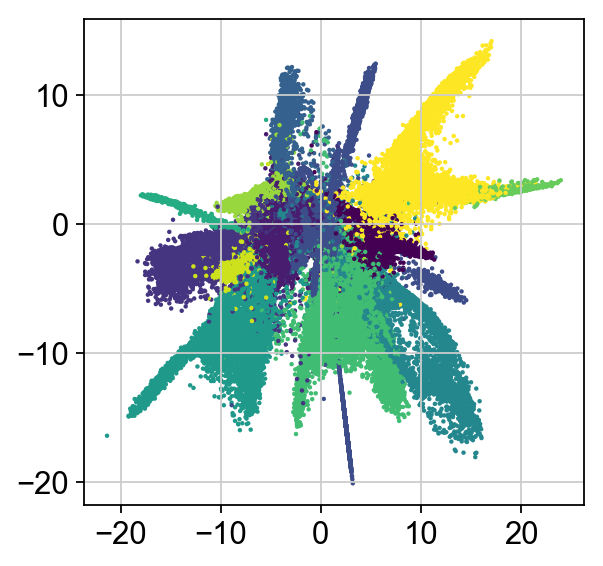

In [20]:
plt.scatter(embeddings[:,0], embeddings[:,1], c = le.fit_transform(bdata.obs["cell types"]), s = 1)